In [3]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from random import random
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

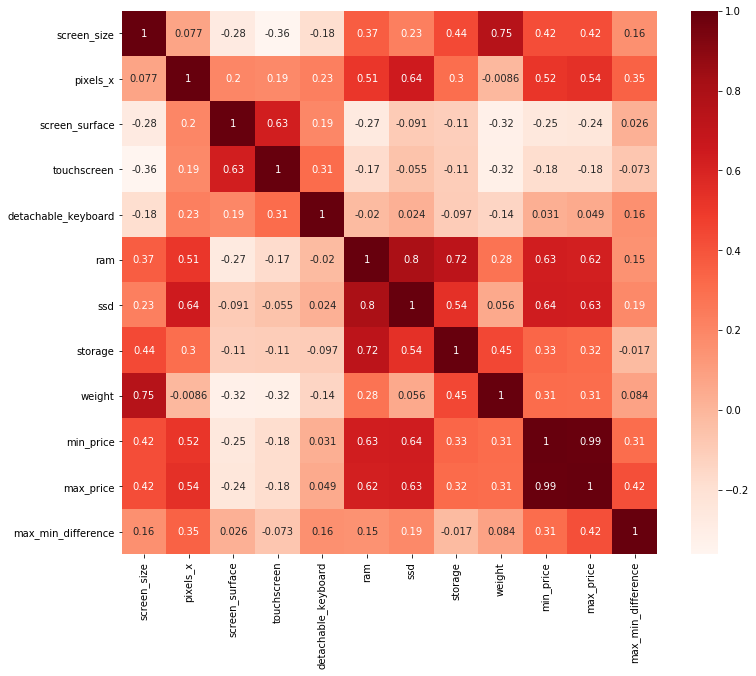

          pixels_x       ram
pixels_x  1.000000  0.512838
ram       0.512838  1.000000
          pixels_x       ssd
pixels_x  1.000000  0.644952
ssd       0.644952  1.000000
         ram      ssd
ram  1.00000  0.79815
ssd  0.79815  1.00000


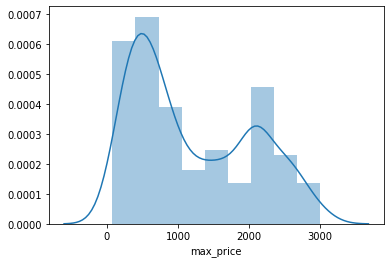

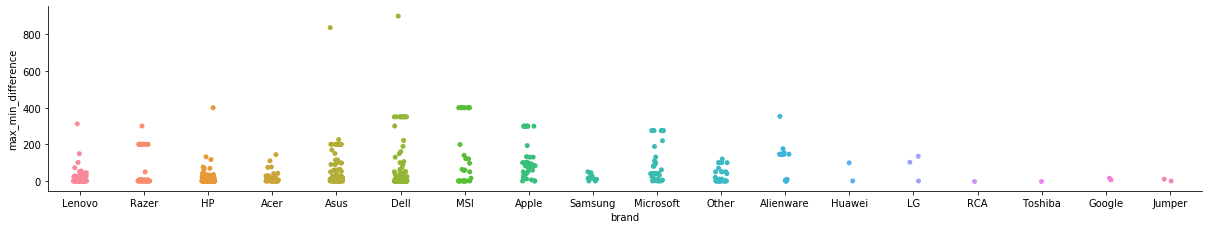

In [4]:
%run "../preprocessing/temporary_preprocessing_pipeline.ipynb"

# 1. Load and divide data into train and test set

In [5]:
# Divide training set into inputs and targets
input_features = final_df_train[final_df_train.columns[:-2]]
targets = final_df_train[final_df_train.columns[-2:]]

# Divide dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_features, targets, test_size=0.10, random_state=42)

# 2. Evaluation functions

In [6]:
 def evaluate_abs_mse(train_rf_predictions,y_train,rf_predictions,y_test): # Pass raw predictions to function
    pred_list_train = train_rf_predictions.tolist()
    target_list_train = y_train.tolist()

    pred_list_test = rf_predictions.tolist()
    target_list_test = y_test.tolist()

    print(f'Absolute mean square error on training set: {mean_absolute_error(target_list_train, pred_list_train)*2}')
    print(f'Absolute mean square error on test set: {mean_absolute_error(pred_list_test, target_list_test)*2}')
    return '-------------- Evaluated --------------'

# 3. Models

### 3.1. Random forest regressor

In [12]:
# Create model (takes a while)
rfr = RandomForestRegressor(n_estimators= 1400,
                            min_samples_split= 5,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 90,
                            bootstrap= False,
                            n_jobs=-1,
                            verbose = 0, 
                           criterion='mae')

# Generated best params for new dataset:
# {'n_estimators': 800,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 90,
#  'bootstrap': False}

# Previous best params
# {'n_estimators': 1400,
#  'min_samples_split': 5,
#  'min_samples_leaf': 1,
#  'max_features': 'sqrt',
#  'max_depth': 80,
#  'bootstrap': False}
# --> Its results: Absolute mean square error on training set: 99.07476881197896
#                  Absolute mean square error on test set: 172.4037810245511

# Train model
rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=False, ccp_alpha=0.0, criterion='mae',
                      max_depth=90, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=1400, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [13]:
# Model parameter evaluation
n_nodes = []
max_depths = []

for ind_tree in rfr.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 455
Average maximum depth 32


In [14]:
# Test model
test_rfr_predictions = rfr.predict(X_test)
train_rfr_predictions = rfr.predict(X_train)

In [15]:
# Reverse values to original values in euros
test_rfr_predictions = min_max_scaler_targets.inverse_transform(test_rfr_predictions)
train_rfr_predictions = min_max_scaler_targets.inverse_transform(train_rfr_predictions)

y_train_reversed = min_max_scaler_targets.inverse_transform(y_train)
y_test_reversed = min_max_scaler_targets.inverse_transform(y_test)

In [16]:
evaluate_abs_mse(train_rfr_predictions,y_train_reversed,test_rfr_predictions,y_test_reversed)

Absolute mean square error on training set: 86.73155768777073
Absolute mean square error on test set: 222.16639125801333


'-------------- Evaluated --------------'

### 3.2. Random Forest Regressor for min and max price separately

In [13]:
# targets_min_norm, max_scaler_targets, min_scaler_targets

input_features = final_df_train[final_df_train.columns[:-2]]
targets = pd.concat([targets_max_norm, targets_min_norm], axis = 1)

# Divide dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_features, targets, test_size=0.10, random_state=42)

In [14]:
# Predict max
rfr_max = RandomForestRegressor(n_estimators= 1000,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 110,
                            bootstrap= True,
                            n_jobs=-1,
                            verbose = 0)

rfr_max.fit(X_train,y_train['max_price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=110, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [15]:
max_prediction = rfr_max.predict(X_test).reshape(-1, 1)
prediction_max = max_scaler_targets.inverse_transform(max_prediction)
y_real_max = max_scaler_targets.inverse_transform(y_test['max_price'].values.reshape(-1, 1))

In [16]:
# Predict min
rfr_min = RandomForestRegressor(n_estimators= 200,
                            min_samples_split= 2,
                            min_samples_leaf= 1,
                            max_features= 'sqrt',
                            max_depth= 50,
                            bootstrap= True,
                            n_jobs=-1,
                            verbose = 0)

rfr_min.fit(X_train,y_train['min_price'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=50, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [17]:
min_prediction = rfr_min.predict(X_test).reshape(-1, 1)
prediction_min = min_scaler_targets.inverse_transform(min_prediction)
y_real_min = min_scaler_targets.inverse_transform(y_test['min_price'].values.reshape(-1, 1))

In [18]:
for i in range(len(prediction_min)):
    if prediction_max[i] <= prediction_min[i]:
        print('max: ', prediction_max[i], 'min: ', prediction_min[i])

max:  [208.28156667] min:  [210.1525]
max:  [1040.72005238] min:  [1072.75]
max:  [1613.606] min:  [1626.08258333]
max:  [281.88788333] min:  [300.21566667]
max:  [407.84567143] min:  [423.81608333]
max:  [172.22766667] min:  [177.73666667]
max:  [646.89742893] min:  [651.63966071]
max:  [680.87981778] min:  [728.11992424]
max:  [457.59895] min:  [482.9775]


In [19]:
full_prediction = pd.concat([pd.DataFrame(prediction_min, columns=['min_price']),
                             pd.DataFrame(prediction_max, columns=['max_price'])], axis=1)

In [20]:
full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['min_price', 'max_price']] = full_prediction.loc[full_prediction['min_price'] > full_prediction['max_price'], ['max_price', 'min_price']].values

In [21]:
sum_abs_min_err, sum_abs_max_err = 0, 0

for i in range(len(full_prediction['min_price'])):
    sum_abs_min_err += abs(full_prediction['min_price'][i] - y_real_min[i])
    sum_abs_max_err += abs(full_prediction['max_price'][i] - y_real_max[i])

(sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))

array([317.51100901])

In [22]:
y_real_min_df = pd.DataFrame(y_real_min, columns = ['min_price'])
y_real_max_df = pd.DataFrame(y_real_max, columns = ['max_price'])

y_real = pd.concat([y_real_min_df, y_real_max_df], axis=1)

In [94]:
# pd.concat([y_real, full_prediction], axis=1)

### 3.3. Neural network

In [20]:
from sklearn.neural_network import MLPRegressor

In [96]:
# Search for best number of neurons and hidden layers
from random import randint
neurons_and_score = []
for it in range(2, 100):
    p1 = randint(1,100)
    p2 = randint(1,100)
    p3 = randint(1,100)
    
    MLP_estimator = MLPRegressor()
    MLP_estimator.set_params(random_state=42, max_iter=1000, hidden_layer_sizes=(p1, p2, p3),
                            )
    MLP_estimator.fit(X_train, y_train)
    
    # Calculate error
    predictions = MLP_estimator.predict(X_test)
    full_prediction = pd.DataFrame(min_max_scaler_targets.inverse_transform(predictions),columns=['min_price', 'max_price'])
    real_targets = pd.DataFrame(min_max_scaler_targets.inverse_transform(y_test),columns=['min_price', 'max_price'])
    
    sum_abs_min_err, sum_abs_max_err = 0, 0

    for i in range(len(full_prediction['min_price'])):
        sum_abs_min_err += abs(full_prediction['min_price'][i] - real_targets['min_price'][i])
        sum_abs_max_err += abs(full_prediction['max_price'][i] - real_targets['max_price'][i])

    temp_score = (sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))
    
    predictions_train = MLP_estimator.predict(X_train)
    full_prediction_train = pd.DataFrame(min_max_scaler_targets.inverse_transform(predictions_train),columns=['min_price', 'max_price'])
    real_targets_train = pd.DataFrame(min_max_scaler_targets.inverse_transform(y_train),columns=['min_price', 'max_price'])
    
    sum_abs_min_err, sum_abs_max_err = 0, 0

    for i in range(len(full_prediction_train['min_price'])):
        sum_abs_min_err += abs(full_prediction_train['min_price'][i] - real_targets_train['min_price'][i])
        sum_abs_max_err += abs(full_prediction_train['max_price'][i] - real_targets_train['max_price'][i])

    temp_score_train = (sum_abs_min_err + sum_abs_max_err)/(len(full_prediction_train['min_price']))
    
    neurons_and_score.append((temp_score, [p1,p2,p3], temp_score_train))

i_temp = (100000, [1,1,1])
for i in neurons_and_score:
    if i[0] < i_temp[0]:
        i_temp = i

print('best params and score: ', i_temp[:2], 'training performance: ', i_temp[2])

# best params and score:  (309.47728680439906, [32, 6, 21])
# best params and score:  (288.0251124357739, [84, 39, 87])
# best params and score:  (262.19035401234345, [26, 80, 69]) training performance:  229.07193412321593

best params and score:  (262.19035401234345, [26, 80, 69]) training performance:  229.07193412321593


In [97]:
MLP_estimator = MLPRegressor()
MLP_estimator.set_params(random_state=42, max_iter=1000, hidden_layer_sizes=(26, 80, 69))

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(26, 80, 69), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [98]:
MLP_estimator.fit(X_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(26, 80, 69), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=1000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=42, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [100]:
predictions = MLP_estimator.predict(X_test)
full_prediction = pd.DataFrame(min_max_scaler_targets.inverse_transform(predictions),columns=['min_price', 'max_price'])
real_targets = pd.DataFrame(min_max_scaler_targets.inverse_transform(y_test),columns=['min_price', 'max_price'])

sum_abs_min_err, sum_abs_max_err = 0, 0

for i in range(len(full_prediction['min_price'])):
    sum_abs_min_err += abs(full_prediction['min_price'][i] - real_targets['min_price'][i])
    sum_abs_max_err += abs(full_prediction['max_price'][i] - real_targets['max_price'][i])

temp_score = (sum_abs_min_err + sum_abs_max_err)/(len(full_prediction['min_price']))
temp_score

262.19035401234345

## 4. Test models on real test data

In [113]:
# Only for multi-output
final_prediction = min_max_scaler_targets.inverse_transform(rfr.predict(final_df_test))

submission_prices = pd.DataFrame(final_prediction, columns = targets.columns) 
submission_multi = pd.concat([pd.DataFrame(df_laptops_test['id']), submission_prices], axis=1)
submission_multi

,id,min_price,max_price
0,28807,1083.591488,1121.149226
1,22559,423.434643,429.336310
2,28647,688.313333,768.956488
3,22141,541.840833,557.209881
4,26116,2069.884881,2310.904226
...,...,...,...
217,8398,809.170119,834.798690
218,21211,1213.162976,1304.912976
219,22553,2456.718214,2499.283929
220,28808,796.472262,847.413810


In [23]:
# For single predictions
max_prediction_final = rfr_max.predict(final_df_test).reshape(-1, 1)
prediction_max_final = max_scaler_targets.inverse_transform(max_prediction_final)

min_prediction_final = rfr_min.predict(final_df_test).reshape(-1, 1)
prediction_min_final = min_scaler_targets.inverse_transform(min_prediction_final)

prediction_max_final_df = pd.DataFrame(prediction_max_final, columns = ['max_price']) 
prediction_min_final_df = pd.DataFrame(prediction_min_final, columns = ['min_price']) 

submission_prices = pd.concat([prediction_min_final_df, prediction_max_final_df], axis=1) 
submission_singles = pd.concat([pd.DataFrame(df_laptops_test['id']), submission_prices], axis=1)
submission_singles

,id,min_price,max_price
0,28807,1105.964931,1157.721724
1,22559,445.641369,450.168898
2,28647,646.212083,748.845546
3,22141,557.469607,583.026881
4,26116,1526.472500,1656.493833
...,...,...,...
217,8398,749.271440,780.006755
218,21211,1164.987500,1294.444398
219,22553,2269.040000,2253.582000
220,28808,809.270000,870.856452


In [114]:
# Write final df to csv
submission_multi.to_csv(r'../../submission/models_rfr_submission_9.csv', index = False)

# Model experimentation (not important)

In [164]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [165]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr3 = RandomForestRegressor(criterion='mae')
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr3, param_distributions = random_grid, n_iter = 110, cv = 7, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

Fitting 7 folds for each of 110 candidates, totalling 770 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed: 43.1min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 88.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 164.7min
[Parallel(n_jobs=-1)]: Done 770 out of 770 | elapsed: 200.8min finished


RandomizedSearchCV(cv=7, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mae',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [166]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 90,
 'bootstrap': False}

## MAX RFR

In [70]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [71]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr_max = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr_max, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train['max_price'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   35.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.8min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [72]:
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

## MIN RFR

In [73]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [74]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rfr3_min = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfr3_min, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train['min_price'])

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [75]:
rf_random.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}